## Import Required libraries

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
from os.path import basename, join, exists
import pickle,cv2, random, datetime, copy, collections, csv, sklearn, os, warnings, elasticdeform, glob, nrrd
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import pydicom, shutil
import pydicom as dicom
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.activations import sigmoid
from scipy.ndimage import zoom 
from sklearn import metrics
from tensorflow.keras import layers
from time import time
from numpy.random import seed
from skimage import exposure, transform
from skimage.transform import rotate
from scipy import ndimage, misc
import scipy.ndimage as ndimage
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
import SimpleITK as sitk
import matplotlib.pyplot as plt
tf.random.set_seed(42)
np.random.seed(42) 
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

2023-06-13 16:45:21.197422: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Model Blocks (Functions)

In [3]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    #  kernel_regularizer='l1_l2'
    x1 = Conv2D(filters = n_filters, kernel_size = (3, 3),
                kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    
    # second layer
    x2 = Conv2D(filters = n_filters, kernel_size = (3, 3),
                kernel_initializer = 'he_normal', padding = 'same')(x1)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    
    x3 = SqueezeExcite(x2, n_filters//4)
    
    return x3


def rrb_block2(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    nb_chan = K.int_shape(input_tensor)[-1]
    x1 = Conv2D(filters = nb_chan, kernel_size=(3, 3), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)

    # second layer
    x2 = Conv2D(filters = nb_chan,kernel_size=(3, 3), kernel_initializer = 'he_normal', padding = 'same')(x1)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    
    x3 = Conv2D(filters = nb_chan,kernel_size=(1, 1), kernel_initializer = 'he_normal', padding = 'same')(x2)
    x3 = BatchNormalization()(x3)
    x3 = Activation('relu')(x3)
    
    x3 = SqueezeExcite(x3, ratio=4)
    
    out1 = layers.Add()([x1, x2, x3])
    
    nb_chan = K.int_shape(out1)[-1]
    
    y = Conv2D(nb_chan, 1, activation = 'sigmoid', padding = 'same')(out1)
    
    y = layers.Multiply()([y, input_tensor])
        
    return y

def SqueezeExcite(x, ratio=16):
    nb_chan = K.int_shape(x)[-1]

    y = layers.GlobalAveragePooling2D()(x)
    y = layers.Dense(nb_chan // ratio, activation='relu')(y)
    y = layers.Dense(nb_chan, activation='sigmoid')(y)

    y = layers.Multiply()([x, y])
    return y



# def rrb_block2(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
#     """Function to add 2 convolutional layers with the parameters passed to it"""
#     nb_chan = K.int_shape(input_tensor)[-1]
    
#     x3 = SqueezeExcite(input_tensor, ratio=2)
        
#     x3 = Conv2D(filters = nb_chan, kernel_size=(1, 1), kernel_initializer = 'he_normal', padding = 'same')(x3)
#     x3 = BatchNormalization()(x3)
#     x3 = tf.keras.layers.LeakyReLU()(x3)
    
# #     out1 = layers.Add()([x1, x2, x3])
    
#     nb_chan = K.int_shape(x3)[-1]
    
#     y = Conv2D(nb_chan, 1, activation = 'sigmoid', padding = 'same')(x3)
    
#     y = layers.Multiply()([y, input_tensor])
        
#     return y

def rrb_block1(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    x1 = Conv2D(filters = n_filters, kernel_size=(3, 3), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)

    # second layer
    x2 = Conv2D(filters = n_filters,kernel_size=(3, 3), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    
    x3 = Conv2D(filters = n_filters, kernel_size=(1, 1), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)

    out = layers.Add()([x1, x2, x3])
    
    return out

In [4]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate

def ASPP_block(inputs):
    """Implementation of Atrous Spatial Pyramid Pooling block"""
    
    # Define the atrous convolution rates
    rates = [3, 6, 12]
    
    # Apply 1x1 convolution
    conv_1x1 = Conv2D(filters=64, kernel_size=1, activation='relu')(inputs)
    
    # Apply 3x3 atrous convolutions with different rates
    conv_3x3_rate_1 = Conv2D(filters=64, kernel_size=3, dilation_rate=rates[0], padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.3))(inputs)
    conv_3x3_rate_2 = Conv2D(filters=64, kernel_size=3, dilation_rate=rates[1], padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.3))(inputs)
    conv_3x3_rate_3 = Conv2D(filters=64, kernel_size=3, dilation_rate=rates[2], padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.3))(inputs)

    # Concatenate the output of all convolutions
    concat = Concatenate()([conv_1x1, conv_3x3_rate_1, conv_3x3_rate_2, conv_3x3_rate_3])
    
    # Apply 1x1 convolution
    aspp_out = Conv2D(filters=64, kernel_size=1, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.3))(concat)
    
    return aspp_out

import tensorflow as tf

def ghost_module(inputs, filters, kernel_size, ratio=2):
    # Calculate primary and cheap filter sizes
    primary_filters = filters // ratio
    cheap_filters = filters - primary_filters

    # Primary path
    primary_conv = Conv2D(filters=primary_filters, kernel_size=kernel_size, padding='same')(inputs)
    primary_bn = BatchNormalization()(primary_conv)
    primary_output = tf.keras.layers.LeakyReLU()(primary_bn)

    # Cheap path
    cheap_conv = Conv2D(filters=cheap_filters, kernel_size=kernel_size, padding='same')(inputs)
    cheap_bn = BatchNormalization()(cheap_conv)
    cheap_output = tf.keras.layers.LeakyReLU()(cheap_bn)

    # Merge paths
    num_ghosts = ratio - 1
    ghosts = [primary_output]
    for i in range(num_ghosts):
        ghost_output = tf.concat([primary_output, cheap_output[:, :, :, i::num_ghosts]], axis=-1)
        ghosts.append(ghost_output)
    output = tf.concat(ghosts, axis=-1)

    return output

def SKConv(inputs, filters, stride=1, r=16):
    # Compute number of groups
    groups = filters // 4

    # Branch 1: Global average pooling
    gap = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    dense1 = tf.keras.layers.Dense(filters // r, activation=tf.keras.layers.LeakyReLU(alpha=0.3))(gap)
    dense2 = tf.keras.layers.Dense(groups, activation='sigmoid')(dense1)

    # Reshape and tile the kernel weights
    gap_reshaped = tf.reshape(dense2, [-1, 1, 1, groups])
    kernel_weights = tf.tile(gap_reshaped, [1, tf.shape(inputs)[1], tf.shape(inputs)[2], 1])

    # Branch 2: Convolutional layers
    conv1 = Conv2D(filters, kernel_size=1, strides=stride)(inputs)
    conv2 = Conv2D(filters, kernel_size=3, strides=stride, padding='same')(inputs)
    conv3 = Conv2D(filters, kernel_size=6, strides=stride, padding='same')(inputs)
    conv4 = Conv2D(filters, kernel_size=12, strides=stride, padding='same')(inputs)

    # Grouped convolutions
    conv = tf.keras.layers.concatenate([conv1, conv2, conv3, conv4], axis=-1)
    grouped_conv = tf.split(conv, groups, axis=-1)
    grouped_weights = tf.split(kernel_weights, groups, axis=-1)

    # Multiply with kernel weights
    weighted_sum = []
    for i in range(groups):
        weighted_sum.append(grouped_conv[i] * grouped_weights[i])

    # Concatenate and apply activation function
    sk_output = tf.keras.layers.concatenate(weighted_sum, axis=-1)
    sk_output = tf.keras.layers.LeakyReLU()(sk_output)

    return sk_output

def res_block(x, n_filters, count):
    if count == 4:
        
        x1 = Conv2D(filters = n_filters, kernel_size = (3, 3),kernel_initializer = 'he_normal', padding = 'same')(x)
        x1 = BatchNormalization()(x1)
        x1 = Activation('relu')(x1)
        x2 = Conv2D(filters = n_filters, kernel_size = (1, 1),kernel_initializer = 'he_normal', padding = 'same')(x)
        x2 = BatchNormalization()(x2)
        x2 = Activation('relu')(x2)
        x3 = Add()([x1, x2])
        
        x4 = Conv2D(filters = n_filters, kernel_size = (3, 3),kernel_initializer = 'he_normal', padding = 'same')(x3)
        x4 = BatchNormalization()(x4)
        x4 = Activation('relu')(x4)
        x5 = Conv2D(filters = n_filters, kernel_size = (1, 1),kernel_initializer = 'he_normal', padding = 'same')(x3)
        x5 = BatchNormalization()(x5)
        x5 = Activation('relu')(x5)
        x6 = Add()([x4, x5])
        
        x7 = Conv2D(filters = n_filters, kernel_size = (3, 3),kernel_initializer = 'he_normal', padding = 'same')(x6)
        x7 = BatchNormalization()(x7)
        x7 = Activation('relu')(x7)
        x8 = Conv2D(filters = n_filters, kernel_size = (1, 1),kernel_initializer = 'he_normal', padding = 'same')(x6)
        x8 = BatchNormalization()(x8)
        x8 = Activation('relu')(x8)
        x9 = Add()([x7, x8])
        
        x10 = Conv2D(filters = n_filters, kernel_size = (3, 3),kernel_initializer = 'he_normal', padding = 'same')(x9)
        x10 = BatchNormalization()(x10)
        x10 = Activation('relu')(x10)
        x11 = Conv2D(filters = n_filters, kernel_size = (1, 1),kernel_initializer = 'he_normal', padding = 'same')(x9)
        x11 = BatchNormalization()(x11)
        x11 = Activation('relu')(x11)
        x12 = Add()([x10, x11])
        
        x13 = SqueezeExcite(x12, n_filters//4)
        return x13
    
    elif count == 3:
        
        x1 = Conv2D(filters = n_filters, kernel_size = (3, 3),kernel_initializer = 'he_normal', padding = 'same')(x)
        x1 = BatchNormalization()(x1)
        x1 = Activation('relu')(x1)
        x2 = Conv2D(filters = n_filters, kernel_size = (1, 1),kernel_initializer = 'he_normal', padding = 'same')(x)
        x2 = BatchNormalization()(x2)
        x2 = Activation('relu')(x2)
        x3 = Add()([x1, x2])
        
        x4 = Conv2D(filters = n_filters, kernel_size = (3, 3),kernel_initializer = 'he_normal', padding = 'same')(x3)
        x4 = BatchNormalization()(x4)
        x4 = Activation('relu')(x4)
        x5 = Conv2D(filters = n_filters, kernel_size = (1, 1),kernel_initializer = 'he_normal', padding = 'same')(x3)
        x5 = BatchNormalization()(x5)
        x5 = Activation('relu')(x5)
        x6 = Add()([x4, x5])
        
        x7 = Conv2D(filters = n_filters, kernel_size = (3, 3),kernel_initializer = 'he_normal', padding = 'same')(x6)
        x7 = BatchNormalization()(x7)
        x7 = Activation('relu')(x7)
        x8 = Conv2D(filters = n_filters, kernel_size = (1, 1),kernel_initializer = 'he_normal', padding = 'same')(x6)
        x8 = BatchNormalization()(x8)
        x8 = Activation('relu')(x8)
        x9 = Add()([x7, x8])
        
        x10 = SqueezeExcite(x9, n_filters//4)
        
        return x10
    
    elif count == 2:
        
        x1 = Conv2D(filters = n_filters, kernel_size = (3, 3),kernel_initializer = 'he_normal', padding = 'same')(x)
        x1 = BatchNormalization()(x1)
        x1 = Activation('relu')(x1)
        x2 = Conv2D(filters = n_filters, kernel_size = (1, 1),kernel_initializer = 'he_normal', padding = 'same')(x)
        x2 = BatchNormalization()(x2)
        x2 = Activation('relu')(x2)
        x3 = Add()([x1, x2])
        
        x4 = Conv2D(filters = n_filters, kernel_size = (3, 3),kernel_initializer = 'he_normal', padding = 'same')(x3)
        x4 = BatchNormalization()(x4)
        x4 = Activation('relu')(x4)
        x5 = Conv2D(filters = n_filters, kernel_size = (1, 1),kernel_initializer = 'he_normal', padding = 'same')(x3)
        x5 = BatchNormalization()(x5)
        x5 = Activation('relu')(x5)
        x6 = Add()([x4, x5])
        
        x7 = SqueezeExcite(x6, n_filters//4)
        
        return x7
    elif count == 1:
        
        x1 = Conv2D(filters = n_filters, kernel_size = (3, 3),kernel_initializer = 'he_normal', padding = 'same')(x)
        x1 = BatchNormalization()(x1)
        x1 = Activation('relu')(x1)
        x2 = Conv2D(filters = n_filters, kernel_size = (1, 1),kernel_initializer = 'he_normal', padding = 'same')(x)
        x2 = BatchNormalization()(x2)
        x2 = Activation('relu')(x2)
        x3 = Add()([x1, x2])
        
        x4 = SqueezeExcite(x3, n_filters//4)
        
        return x4

## The Model Layers
### The Backbone can be any model from keras Applications

## U-Model with Parallel Convolution Block & Attention Block:

In [5]:

from tensorflow.keras.layers import ZeroPadding2D,BatchNormalization,MaxPooling2D, UpSampling2D,Dropout,multiply, Concatenate, Conv2D, Add, Activation

def UNet_Seg(input_img, n_filters = 32, dropout = 0.5, batchnorm = True):
    # set image specifics
    k = 3 # kernel size
    s = 2 # stride
    img_ch = 1 # image channels
    padding = 'same'
    batchnorm = True
    dropout = 0.5

    c0 = layers.Cropping2D(cropping = ((96,96), (96,96)))(input_img)    
    c1 = conv2d_block(c0, n_filters * 1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 6)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    p4 = layers.Dropout(dropout)(p4)


    # D1
    conv4_1 = conv2d_block(p4, n_filters * 8)
    conv4_1 = Dropout(dropout)(conv4_1)


    u6 = layers.UpSampling2D(size = (2,2))(conv4_1)
    u6 = layers.concatenate([u6, c4], axis = 3)
    c6 = conv2d_block(u6, n_filters * 6)
    c6 = layers.Dropout(dropout)(c6)


    u7 = UpSampling2D(size = (2,2))(c6) 
    u7 = layers.concatenate([u7, c3], axis = 3)
    c7 = conv2d_block(u7, n_filters * 4)
    c7 = layers.Dropout(dropout)(c7)

    u8 = layers.UpSampling2D(size = (2,2))(c7)
    u8 = layers.concatenate([u8, c2], axis = 3)
    c8 = conv2d_block(u8, n_filters * 2)
    c8 = layers.Dropout(dropout)(c8)

    u9 = layers.UpSampling2D(size = (2,2))(c8)
    u9 = layers.concatenate([u9, c1], axis = 3)
    c9 = conv2d_block(u9, n_filters * 1)
    c9 = layers.Dropout(dropout)(c9)

    output1 = Conv2D(1, (1, 1), padding=padding, activation='sigmoid', name="out1")(c9)
    output_1 = layers.ZeroPadding2D((96,96))(output1)    


    model = tf.keras.Model(inputs=input_img, outputs=output_1)
    
    return model

## Required losses and Metrics

In [6]:
def dice_acc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
 
# jacard accuracy
def jacard_acc(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score


def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_f = K.cast(y_true, 'float32')
    y_pred_f = K.cast(y_pred, 'float32')
    y_true_pos = K.flatten(y_true_f)
    y_pred_pos = K.flatten(y_pred_f)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)


def weighted_bce_loss(y_true, y_pred, weight):
    # avoiding overflow
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))

    # https://www.tensorflow.org/api_docs/python/tf/nn/weighted_cross_entropy_with_logits
    loss = (1. - y_true) * logit_y_pred + (1. + (weight - 1.) * y_true) * \
           (K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)


def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight * weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss


def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd number
    averaged_mask = K.pool2d(
        y_true, pool_size=(1, 1), strides=(1, 1), padding='same', pool_mode='avg')
    border = K.cast(K.greater(averaged_mask, 0.01), 'float32') * K.cast(K.less(averaged_mask, 0.99), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
#     loss = weighted_bce_loss(y_true, y_pred, weight) + focal_tversky_loss(y_true, y_pred) + weighted_dice_loss(y_true, y_pred, weight)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

def loss(y_true, y_pred):
    def dice_loss(y_true, y_pred):
        numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
        denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

        return tf.reshape(1 - numerator / denominator, (-1, 1, 1))

    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [7]:

def calc_DSC(truth, pred, classes=2):
    dice_scores = []
    # Iterate over each class
    for i in range(classes):
        try:
            gt = np.equal(truth, i)
            pd = np.equal(pred, i)
            # Calculate Dice
            dice = 2*np.logical_and(pd, gt).sum() / (pd.sum() + gt.sum())
            dice_scores.append(dice)
        except ZeroDivisionError:
            dice_scores.append(0.0)
    # Return computed Dice Similarity Coefficients
    return dice_scores

def calc_IoU(truth, pred, classes):
    iou_scores = []
    # Iterate over each class
    for i in range(classes):
        try:
            gt = np.equal(truth, i)
            pd = np.equal(pred, i)
            # Calculate iou
            iou = np.logical_and(pd, gt).sum() / (pd.sum() + gt.sum() - np.logical_and(pd, gt).sum())
            iou_scores.append(iou)
        except ZeroDivisionError:
            iou_scores.append(0.0)
    # Return computed IoU
    return iou_scores[1]


def calc_Sensitivity(truth, pred, classes):
    sens_scores = []
    # Iterate over each class
    for i in range(classes):
        try:
            gt = np.equal(truth, i)
            pd = np.equal(pred, i)
            # Calculate sensitivity
            sens = np.logical_and(pd, gt).sum() / gt.sum()
            sens_scores.append(sens)
        except ZeroDivisionError:
            sens_scores.append(0.0)
    # Return computed sensitivity scores
    return sens_scores[1]

def calc_Specificity(truth, pred, classes):
    spec_scores = []
    # Iterate over each class
    for i in range(classes):
        try:
            not_gt = np.logical_not(np.equal(truth, i))
            not_pd = np.logical_not(np.equal(pred, i))
            # Calculate specificity
            spec = np.logical_and(not_pd, not_gt).sum() / (not_gt).sum()
            spec_scores.append(spec)
        except ZeroDivisionError:
            spec_scores.append(0.0)
    # Return computed specificity scores
    return spec_scores[1]

def calc_Accuracy(truth, pred, classes):
    acc_scores = []
    # Iterate over each class
    for i in range(classes):
        try:
            gt = np.equal(truth, i)
            pd = np.equal(pred, i)
            not_gt = np.logical_not(np.equal(truth, i))
            not_pd = np.logical_not(np.equal(pred, i))
            # Calculate accuracy
            acc = (np.logical_and(pd, gt).sum() + \
                   np.logical_and(not_pd, not_gt).sum()) /  gt.size
            acc_scores.append(acc)
        except ZeroDivisionError:
            acc_scores.append(0.0)
    # Return computed accuracy scores
    return acc_scores[1]

def calc_Precision(truth, pred, classes):
    prec_scores = []
    # Iterate over each class
    for i in range(classes):
        try:
            gt = np.equal(truth, i)
            pd = np.equal(pred, i)
            # Calculate precision
            prec = np.logical_and(pd, gt).sum() / pd.sum()
            prec_scores.append(prec)
        except ZeroDivisionError:
            prec_scores.append(0.0)
    # Return computed precision scores
    return prec_scores[1]

In [8]:
def norm(x):
    x_norm = cv2.normalize(x, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return x_norm

### Data Path

In [9]:

vol_3 = '/home/saacfb/Projects/Bladder/Autosegmentation/subject 3/mri dicom/'
vol_4 = '/home/saacfb/Projects/Bladder/Autosegmentation/subject 4 newer/5_MRI DICOM/'
vol_12 = '/home/saacfb/Projects/Bladder/Autosegmentation/subject 12/MRI DICOM/'
vol_13 = '/home/saacfb/Projects/Bladder/Autosegmentation/subject 13/MRI DICOM/'
vol_18 = '/home/saacfb/Projects/Bladder/Autosegmentation/SUBJECT_18/SUB18_Original_DICOM/DICOM/1.3.6.1.4.1.18047.1.11.11599577220599/5/'
vol_20 = '/home/saacfb/Projects/Bladder/Autosegmentation/SUBJECT_20/SUB20_Original_DICOM/DICOM/1.3.6.1.4.1.18047.1.11.11607956361266/2/'
vol_29 = '/home/saacfb/Projects/Bladder/Autosegmentation/subj 29 new/2 dicom/'



seg_3 = '/home/saacfb/Projects/Bladder/Autosegmentation/subject 3/bladder.nrrd'
seg_4 = '/home/saacfb/Projects/Bladder/Autosegmentation/subject 4 newer/Segmentation_1.nrrd'
seg_12 = '/home/saacfb/Projects/Bladder/Autosegmentation/subject 12/Segmentation.nrrd'
seg_13 = '/home/saacfb/Projects/Bladder/Autosegmentation/subject 13/bladder.nrrd'
seg_18 = '/home/saacfb/Projects/Bladder/Autosegmentation/SUBJECT_18/SUB18_Segmentation/Segmentation.nrrd'
seg_20 = '/home/saacfb/Projects/Bladder/Autosegmentation/SUBJECT_20/SUB20_Segmentation/Segmentation.nrrd'
seg_29 = '/home/saacfb/Projects/Bladder/Autosegmentation/subj 29 new/Segmentation.nrrd'

### Empyt lists as a place holders for the training and validatin data

In [10]:
x_train3 = []

x_train4 = []

x_train12 = []

x_train13 = []

x_train18 = []

x_train20 = []

x_test29 = []

### Loading, normalizing, and resizing the training data

In [11]:
# load the DICOM files
files3 = []
print('glob: {}'.format(vol_3))
for fname in sorted(glob.glob(vol_3+"*.dcm", recursive=False)):
    files3.append(pydicom.dcmread(fname))

print("file count: {}".format(len(files3)))

# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files3:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

print("skipped, no SliceLocation: {}".format(skipcount))


# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)

for x in slices:
#     img = cv2.resize(x.pixel_array, (256, 256))
    x_train3.append(x.pixel_array)
    

y_train3, header3 = nrrd.read(seg_3)
y_train3 = np.transpose(y_train3)

###############################################

# # load the DICOM files
# files4 = []
# print('glob: {}'.format(vol_4))
# for fname in sorted(glob.glob(vol_4+"*.dcm", recursive=False)):
#     files4.append(pydicom.dcmread(fname))

# print("file count: {}".format(len(files4)))

# # skip files with no SliceLocation (eg scout views)
# slices = []
# skipcount = 0
# for f in files4:
#     if hasattr(f, 'SliceLocation'):
#         slices.append(f)
#     else:
#         skipcount = skipcount + 1

# print("skipped, no SliceLocation: {}".format(skipcount))


# # ensure they are in the correct order
# slices = sorted(slices, key=lambda s: s.SliceLocation)

# for x in slices:
# #     img = cv2.resize(x.pixel_array, (256, 256))
#     x_train4.append(x.pixel_array)
    

# y_train4, header4 = nrrd.read(seg_4)
# y_train4 = np.transpose(y_train4)

################################################


# # load the DICOM files
# files12 = []
# print('glob: {}'.format(vol_12))
# for fname in sorted(glob.glob(vol_12+"*.dcm", recursive=False)):
#     files12.append(pydicom.dcmread(fname))

# print("file count: {}".format(len(files12)))

# # skip files with no SliceLocation (eg scout views)
# slices = []
# skipcount = 0
# for f in files12:
#     if hasattr(f, 'SliceLocation'):
#         slices.append(f)
#     else:
#         skipcount = skipcount + 1

# print("skipped, no SliceLocation: {}".format(skipcount))


# # ensure they are in the correct order
# slices = sorted(slices, key=lambda s: s.SliceLocation)

# for x in slices:
# #     img = cv2.resize(x.pixel_array, (256, 256))
#     x_train12.append(x.pixel_array)
    

# y_train12, header12 = nrrd.read(seg_12)
# y_train12 = np.transpose(y_train12)


###################################################

# # load the DICOM files
# files13 = []
# print('glob: {}'.format(vol_13))
# for fname in sorted(glob.glob(vol_13+"*.dcm", recursive=False)):
#     files13.append(pydicom.dcmread(fname))

# print("file count: {}".format(len(files13)))

# # skip files with no SliceLocation (eg scout views)
# slices = []
# skipcount = 0
# for f in files13:
#     if hasattr(f, 'SliceLocation'):
#         slices.append(f)
#     else:
#         skipcount = skipcount + 1

# print("skipped, no SliceLocation: {}".format(skipcount))


# # ensure they are in the correct order
# slices = sorted(slices, key=lambda s: s.SliceLocation)

# for x in slices:
# #     img = cv2.resize(x.pixel_array, (256, 256))
#     x_train13.append(x.pixel_array)
    

# y_train13, header13 = nrrd.read(seg_13)
# x_train13 = np.swapaxes(x_train13, 1, 2)
# y_train13 = np.transpose(y_train13)

glob: /home/saacfb/Projects/Bladder/Autosegmentation/subject 3/mri dicom/
file count: 60
skipped, no SliceLocation: 0


In [12]:
# load the DICOM files
files18 = []
print('glob: {}'.format(vol_18))
for fname in sorted(glob.glob(vol_18+"*.dcm", recursive=False)):
    files18.append(pydicom.dcmread(fname))

print("file count: {}".format(len(files18)))

# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files18:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

print("skipped, no SliceLocation: {}".format(skipcount))


# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)

for x in slices:
    x_train18.append(x.pixel_array)
    

y_train18, header18 = nrrd.read(seg_18)
y_train18 = np.transpose(y_train18)

glob: /home/saacfb/Projects/Bladder/Autosegmentation/SUBJECT_18/SUB18_Original_DICOM/DICOM/1.3.6.1.4.1.18047.1.11.11599577220599/5/
file count: 63
skipped, no SliceLocation: 0


In [13]:
# load the DICOM files
files20 = []
print('glob: {}'.format(vol_20))
for fname in sorted(glob.glob(vol_20+"*.dcm", recursive=False)):
    files20.append(pydicom.dcmread(fname))

print("file count: {}".format(len(files20)))

# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files20:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

print("skipped, no SliceLocation: {}".format(skipcount))


# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)

for x in slices:
    x_train20.append(x.pixel_array)
    

y_train20, header20 = nrrd.read(seg_20)
y_train20 = np.transpose(y_train20)

glob: /home/saacfb/Projects/Bladder/Autosegmentation/SUBJECT_20/SUB20_Original_DICOM/DICOM/1.3.6.1.4.1.18047.1.11.11607956361266/2/
file count: 63
skipped, no SliceLocation: 0


In [14]:
# load the DICOM files
files29 = []
print('glob: {}'.format(vol_29))
for fname in sorted(glob.glob(vol_29+"*.dcm", recursive=False)):
    files29.append(pydicom.dcmread(fname))

print("file count: {}".format(len(files29)))

# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files29:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

print("skipped, no SliceLocation: {}".format(skipcount))


# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)

# PNG = False
index = 0
for x in slices:
    x_test29.append(x.pixel_array)
#     plt.imsave('/home/saacfb/Projects/Bladder/Autosegmentation/subj 29 new/images/'+str(index)+'.png', x.pixel_array)
#     index = index+1
    

    

y_test29, header29 = nrrd.read(seg_29)
y_test29 = np.transpose(y_test29)




glob: /home/saacfb/Projects/Bladder/Autosegmentation/subj 29 new/2 dicom/
file count: 57
skipped, no SliceLocation: 0


In [ ]:
# def get_names(path):
#     names = []
#     for root, dirnames, filenames in os.walk(path):
#         for filename in filenames:
#             _, ext = os.path.splitext(filename)
#             if ext in ['.dcm']:
#                 names.append(filename)
    
#     return names

# def convert_dcm_jpg(name):
    
#     im = pydicom.dcmread('/home/saacfb/Projects/Bladder/Autosegmentation/subject 3/mri dicom/'+name)

#     im = im.pixel_array.astype(float)

#     rescaled_image = (np.maximum(im,0)/im.max())*255 # float pixels
#     final_image = np.uint8(rescaled_image) # integers pixels

#     final_image = Image.fromarray(final_image)

#     return final_image

In [ ]:
# names = get_names('/home/saacfb/Projects/Bladder/Autosegmentation/subject 3/mri dicom/')
# for name in names:
#     image = convert_dcm_jpg(name)
#     image.save('/home/saacfb/Projects/Bladder/Autosegmentation/subject 3/images/'+name+'.png')

### Loading, normalizing, and resizing the testing data

### Converting the data lists into numpy arrays

In [15]:


print(len(x_train3))
print(len(y_train3))

x_train3 = np.array(x_train3)
y_train3 = np.array(y_train3)

print(x_train3.shape)
print(y_train3.shape)
print('.....subject 3.......')
print("\n")
###################################

# print(len(x_train4))
# print(len(y_train4))

# x_train4 = np.array(x_train4)
# y_train4 = np.array(y_train4)

# print(x_train4.shape)
# print(y_train4.shape)
# print('.....subject .......')
# print("\n")
###################################


# print(len(x_train12))
# print(len(y_train12))

# x_train12 = np.array(x_train12)
# y_train12 = np.array(y_train12)

# print(x_train12.shape)
# print(y_train12.shape)
# print('.....subject 12.......')
# print("\n")
#####################################

# print(len(x_train13))
# print(len(y_train13))

# x_train13 = np.array(x_train13)
# y_train13 = np.array(y_train13)

# print(x_train13.shape)
# print(y_train13.shape)
# print('.....subject 13.......')
# print("\n")
#####################################
print(len(x_train18))
print(len(y_train18))

x_train18 = np.array(x_train18)
y_train18 = np.array(y_train18)

print(x_train18.shape)
print(y_train18.shape)

print('.....subject 18.......')
print("\n")
#####################################

print(len(x_train20))
print(len(y_train20))

x_train20 = np.array(x_train20)
y_train20 = np.array(y_train20)

print(x_train20.shape)
print(y_train20.shape)
print('.....subject 20.......')
print("\n")
#######################################
print(len(x_test29))
print(len(y_test29))

x_test29 = np.array(x_test29)
y_test29 = np.array(y_test29)

print(x_test29.shape)
print(y_test29.shape)
print('.....subject 29 new.......')

60
60
(60, 256, 256)
(60, 256, 256)
.....subject 3.......


63
63
(63, 256, 256)
(63, 256, 256)
.....subject 18.......


63
63
(63, 256, 256)
(63, 256, 256)
.....subject 20.......


57
57
(57, 256, 256)
(57, 256, 256)
.....subject 29 new.......


In [ ]:
# y_train4[y_train4 < 3] = 0
# y_train4[y_train4 == 3] = 1
# y_train4[y_train4 > 3] = 0

In [16]:
y_train3[y_train3 < 5] = 0
y_train3[y_train3 == 5] = 1
y_train3[y_train3 > 5] = 0

In [17]:
y_train18[y_train18 < 2] = 0
y_train18[y_train18 == 2] = 1
y_train18[y_train18 > 2] = 0

In [18]:
y_train20[y_train20 < 3] = 0
y_train20[y_train20 == 3] = 1
y_train20[y_train20 > 3] = 0


In [19]:
y_test29[y_test29 < 3] = 0
y_test29[y_test29 == 3] = 0
y_test29[y_test29 == 4] = 1
y_test29[y_test29 > 4] = 0




## Converting numpy to images

In [ ]:
# def save_image_from_dicom(path, array, label=False):
#     index = 0
#     for x in array:
# #         bw_mask = np.where(x > 0, 255, 0).astype(np.uint8)
#         if label:
#             bw_mask = np.where(x > 0, 255, 0).astype(np.uint8)
#             plt.imsave(path+str(index)+'_seg.png', bw_mask, cmap='gray')
#         index = index+1
    
#     return
    

In [ ]:
def save_image_from_dicom(path, array, label=False):
    index = 0
    for x in array:
        if label:
            bw_mask = np.where(x > 0, 255, 0).astype(np.uint8)
            plt.imsave(path+str(index)+'_seg.png', bw_mask, cmap='gray')
        else:
            plt.imsave(path+str(index)+'.png', x)
        index = index+1
    
    return
    

In [ ]:
save_image_from_dicom('/home/saacfb/Projects/Bladder/Autosegmentation/subject 3/images/', x_train3, label=False)

In [ ]:
save_image_from_dicom('/home/saacfb/Projects/Bladder/Autosegmentation/subject 3/masks/', y_train3, label=True)

In [ ]:
# index = 0
# for x in y_train3:
#     plt.imsave('/home/saacfb/Projects/Bladder/Autosegmentation/subject 3/masks/'+str(index)+'.png', x)
#     index = index+1
    

In [ ]:
# plt.imsave('/home/saacfb/Projects/Bladder/Autosegmentation/subject 3/masks/30.png', y_test29[30])


### Concatenate subjects for training 

In [20]:
x_train = np.concatenate((x_train3, x_train18, x_train20), axis=0)
print(x_train.shape)

(186, 256, 256)


In [21]:
y_train = np.concatenate((y_train3, y_train18, y_train20), axis=0)
print(y_train.shape)

(186, 256, 256)


In [ ]:
# # Normalize the augnmented images (in-case of intesity changes):
# for s in range(x_train.shape[0]):
#     x_train[s] = norm(x_train[s])

In [22]:
unique, counts = np.unique(y_train3, return_counts=True)

dict(zip(unique, counts))

{0: 3914074, 1: 18086}

In [23]:
unique, counts = np.unique(y_train18, return_counts=True)

dict(zip(unique, counts))

{0: 4125854, 1: 2914}

In [24]:
unique, counts = np.unique(y_train20, return_counts=True)

dict(zip(unique, counts))

{0: 4118594, 1: 10174}

In [25]:
unique, counts = np.unique(y_test29, return_counts=True)

dict(zip(unique, counts))

{0: 3731451, 1: 4101}

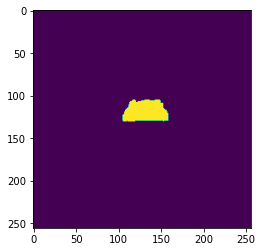

In [26]:
plt.imshow(y_train3[27])#, cmap='gray')
plt.show()


In [ ]:
import matplotlib
# colors = ['black','green','blue','purple', 'red','white', 'yellow', 'brown', 'silver', 'gold']
plt.rcParams['figure.figsize'] = [20, 10]
# plt.imshow(slices[20].pixel_array, cmap='gray')
# plt.imshow(slices[30].pixel_array, cmap='gray')
plt.imshow(x_train3[25])

plt.imshow(y_train3[25], alpha =0.1)
plt.show()

In [ ]:
# # ensure they are in the correct order
# slices = sorted(slices, key=lambda s: s.SliceLocation)

# # pixel aspects, assuming all slices are the same
# ps = slices[0].PixelSpacing
# ss = slices[0].SliceThickness
# ax_aspect = ps[1]/ps[0]
# sag_aspect = ps[1]/ss
# cor_aspect = ss/ps[0]

# # create 3D array
# img_shape = list(slices[0].pixel_array.shape)
# img_shape.append(len(slices))
# img3d=np.zeros(img_shape)

# # fill 3D array with the images from the files
# for i, s in enumerate(slices):
#     img2d = s.pixel_array
#     img3d[:,:,i] = img2d

# print(img3d.shape)
# # plot 3 orthogonal slices
# a1 = plt.subplot(2,2,1)
# plt.imshow(img3d[:,:,0])
# a1.set_aspect(ax_aspect)

# a2 = plt.subplot(2,2,2)
# plt.imshow(img3d[:,img_shape[1]//2,:])
# a2.set_aspect(sag_aspect)

# a3 = plt.subplot(2,2,3)
# plt.imshow(img3d[img_shape[0]//2,:,:].T)
# a3.set_aspect(cor_aspect)

# plt.show()

In [ ]:
# # Convert the Image Orientation Patient tag cosine values into a text string of the plane.
# # This represents the plane the image is 'closest to' .. it does not explain any obliqueness
# def get_image_plane(loc):

#     row_x = round(loc[0])
#     row_y = round(loc[1])
#     row_z = round(loc[2])
#     col_x = round(loc[3])
#     col_y = round(loc[4])
#     col_z = round(loc[5])

#     if row_x == 1 and row_y == 0 and col_x == 0 and col_y == 0:
#         return "Coronal"

#     if row_x == 0 and row_y == 1 and col_x == 0 and col_y == 0:
#         return "Sagittal"

#     if row_x == 1 and row_y == 0 and col_x == 0 and col_y == 1:
#         return "Axial"

#     return "Unknown"

# # Display images and their plane
# def plot_images(images):
    
#     for img in images:
#         fig = plt.figure(figsize=(5, 5))
#         image = img
#         image_orientation_patient = image[0x0020,0x0037]
#         plane = get_image_plane(image_orientation_patient)
#         plt.title(" - " + plane)
#         plt.imshow(image.pixel_array, cmap='gray')

In [ ]:
# # ID / Directory name of the study we want to get
# plot_images(files12[31:33])
# # plot_images(seg_12[31:33])

In [ ]:
# for x in range (y_train3.shape[0]):
#     unique, counts = np.unique(y_train3[x], return_counts=True)
#     print(dict(zip(unique, counts)))

### Normalize testing subject

In [27]:
# Normalize the augnmented images (in-case of intesity changes):
for s in range(y_test29.shape[0]):
    y_test29[s] = norm(y_test29[s])

### Changing the labels into categorical using the number of classes

In [28]:
print(y_train.shape)
print(y_test29.shape)

(186, 256, 256)
(57, 256, 256)


In [29]:
# Remove Non-bladder Slices:
X_train_2 = []
y_train_2 = []
X_test_2 = []
y_test_2 = []

for i in range(y_train.shape[0]):
    if np.any(y_train[i]) :
        X_train_2.append(x_train[i])
        y_train_2.append(y_train[i])

for i in range(y_test29.shape[0]):
    if np.any(y_test29[i]):
        X_test_2.append(x_test29[i])
        y_test_2.append(y_test29[i])


X_train_2 = np.array(X_train_2)
y_train_2 = np.array(y_train_2)
X_test_2 = np.array(X_test_2)
y_test_2 = np.array(y_test_2)


print(x_train.shape)
print(y_train.shape)
print(x_test29.shape)
print(y_test29.shape)
print()
print(X_train_2.shape)
print(y_train_2.shape)
print(X_test_2.shape)
print(y_test_2.shape)

(186, 256, 256)
(186, 256, 256)
(57, 256, 256)
(57, 256, 256)

(36, 256, 256)
(36, 256, 256)
(9, 256, 256)
(9, 256, 256)


In [ ]:
# unique, counts = np.unique(y_train_2, return_counts=True)

# dict(zip(unique, counts))

### Apply Data Augmentation

In [30]:
def augment_data(ct_vol_train, seg_vol_train, ct_vol_test, seg_vol_test):
    

    ct_vol_test = np.array(ct_vol_test, dtype='float32')
    
    seg_vol_test = np.array(seg_vol_test, dtype='float32')

    # Augmentation:
    image_list = []
    label_list = []

    
    for x in range(0, len(ct_vol_train)):
        # append original to new lists
        image_list.append(ct_vol_train[x])
        label_list.append(seg_vol_train[x])

    for x in range(0, len(image_list)):

        image = image_list[x] 
        label = label_list[x]        
        
        if np.any(label):
            
            # Image flipping :
            flipped_img = np.fliplr(image)
            flipped_lbl = np.fliplr(label)
            image_list.append(flipped_img)
            label_list.append(flipped_lbl)

            # Image flipping :
            flipp_img = np.flipud(image)
            flipp_lbl = np.flipud(label)
            image_list.append(flipp_img)
            label_list.append(flipp_lbl)

            # Plurring Images
            plurred_img = ndimage.gaussian_filter(image, sigma=0.5)
            image_list.append(plurred_img)
            label_list.append(label)


            # Image Sharpining;
            zoomeed = ndimage.gaussian_filter(image, sigma=0.5)
            filter_blurred_f = ndimage.gaussian_filter(zoomeed, 0.5)
            list_l = [10,15,20,25,30]
            alpha = random.choice(list_l)
            sharpened = zoomeed + alpha * (zoomeed - filter_blurred_f)
            image_list.append(sharpened)
            label_list.append(label)


    #print(image_list)
    image_list = np.array(image_list, dtype='float32')
    label_list = np.array(label_list, dtype='float32')
#     image_list = np.expand_dims(image_list, axis=-1)

    
    # Normalize the augnmented images (in-case of intesity changes):
#     for s in range(image_list.shape[0]):
#         image_list[s] = norm(image_list[s])
    
    return image_list, label_list, ct_vol_test, seg_vol_test

### Calling Data_Augmentation

In [31]:
X_train, Y_train, X_test, Y_test  = augment_data(X_train_2, y_train_2, X_test_2, y_test_2)

print(np.argwhere(np.isnan(X_train)))
print(X_train.shape)
print(np.argwhere(np.isnan(X_test)))
print(X_test.shape)

[]
(180, 256, 256)
[]
(9, 256, 256)


In [32]:
# Normalize the augnmented images (in-case of intesity changes):
for s in range(X_train.shape[0]):
        X_train[s] = norm(X_train[s])

In [33]:
# Normalize the augnmented images (in-case of intesity changes):
for s in range(X_test.shape[0]):
        X_test[s] = norm(X_test[s])

In [34]:
X_train = np.expand_dims(X_train, axis=-1)

X_test = np.expand_dims(X_test, axis=-1)

print(X_train.shape)
print(X_test.shape)

(180, 256, 256, 1)
(9, 256, 256, 1)


In [35]:
Y_train = np.expand_dims(Y_train, axis=-1)

Y_test = np.expand_dims(Y_test, axis=-1)

### Check the Data shapes and values:

In [36]:
print("X_train-", X_train.shape)
print("y_train-", Y_train.shape)
print("X_test-", X_test.shape)
print("y_test-", Y_test.shape)

X_train- (180, 256, 256, 1)
y_train- (180, 256, 256, 1)
X_test- (9, 256, 256, 1)
y_test- (9, 256, 256, 1)


In [37]:
print(np.amax(Y_train))
print(np.amin(Y_train))

print(np.amax(Y_test))
print(np.amin(Y_test))

1.0
0.0
1.0
0.0


In [38]:
print(np.amax(X_train[:]))
print(np.amin(Y_train[:]))

print(np.amax(X_test[:]))
print(np.amin(Y_test[:]))

1.0
0.0
1.0
0.0


### Visualizing some of the Testing/Training Data
#### [0, 1, 2] represent the Classes [Background, Non-Carcinoma, Carcinoma]

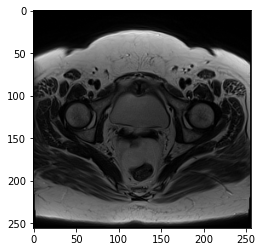

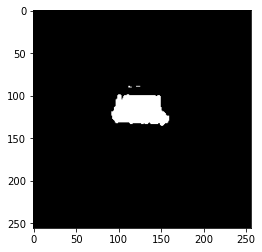

In [39]:
y = 60
plt.imshow(X_train[y], cmap="gray")
plt.show()
plt.imshow(Y_train[y], cmap="gray")
plt.show()

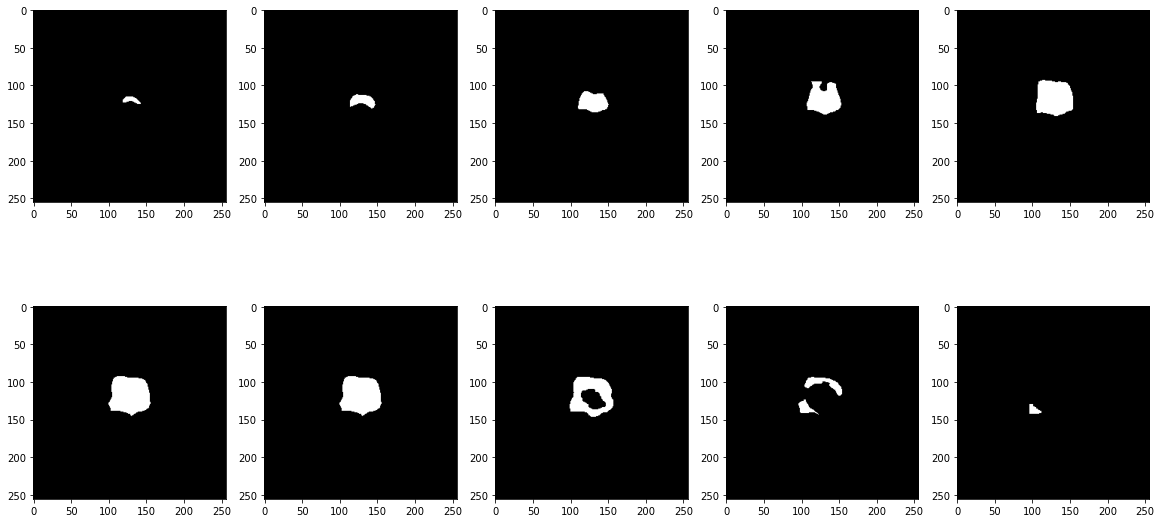

In [40]:
y = 24
# colors = ['black','green','blue','purple', 'red','white', 'yellow', 'brown', 'silver', 'gold']

plt.rcParams['figure.figsize'] = [20, 10]

a1 = plt.subplot(2, 5, 1)
plt.imshow(y_train20[y], cmap='gray')
# plt.imshow(readdata[x,:,:], alpha=0.35)

a2 = plt.subplot(2, 5, 2)
plt.imshow(y_train20[y+1], cmap='gray')
# plt.imshow(readdata[x+10,:,:], alpha=0.53)

a2 = plt.subplot(2, 5, 3)
plt.imshow(y_train20[y+2], cmap='gray')
# plt.imshow(readdata[x+15,:,:],  alpha=0.53)

a2 = plt.subplot(2, 5, 4)
plt.imshow(y_train20[y+3], cmap='gray')
# plt.imshow(readdata[x,:,:], alpha=0.35)

a2 = plt.subplot(2, 5, 5)
plt.imshow(y_train20[y+4], cmap='gray')
# plt.imshow(readdata[x+40,:,:], alpha=0.53)

a2 = plt.subplot(2, 5, 6)
plt.imshow(y_train20[y+5], cmap='gray')
# plt.imshow(readdata[x+5,:,:], alpha=0.5)

a2 = plt.subplot(2, 5, 7)
plt.imshow(y_train20[y+5], cmap='gray')
# plt.imshow(readdata[x+6,:,:], alpha=0.35)

a2 = plt.subplot(2, 5, 8)
plt.imshow(y_train20[y+6], cmap='gray')
# plt.imshow(readdata[x+7,:,:], alpha=0.35)

a2 = plt.subplot(2, 5, 9)
plt.imshow(y_train20[y+7], cmap='gray')
# plt.imshow(readdata[x+8,:,:], alpha=0.35)

a2 = plt.subplot(2, 5,10)
plt.imshow(y_train20[y+8], cmap='gray')
# plt.imshow(readdata[x+20,:,:], alpha=0.35)

plt.show()

## Model Building & Compilation

In [ ]:
input_img = tf.keras.Input((256, 256, 1), name='img1')


model = UNet_Seg(input_img, n_filters =32, dropout = 0.5, batchnorm = True)

model.compile(optimizer=tf.keras.optimizers.Adam(3e-4),
              loss= weighted_bce_dice_loss,
              metrics=[dice_acc,jacard_acc])

model.summary()

## Transfer Model

In [50]:
from tensorflow.keras.applications import MobileNetV2, EfficientNetB5, EfficientNetB7, VGG19, VGG16, ResNet152V2

In [51]:

  

def build_VGG19_unet(input_shape, n_filters=32, dropout=0.2):
    
    encoder =  VGG19(input_tensor=input_shape, weights=None, include_top=False)
#     encoder.summary()
    
    
    c40 = encoder.get_layer(index=20).output
    c41 = conv2d_block(c40, n_filters * 8)  #32*32
    c42 = Dropout(dropout)(c41)


    # Decoder path
    u6 = layers.UpSampling2D(size=(2, 2))(c42) # 64*64
    u62 = layers.Concatenate()([u6, encoder.get_layer(index=15).output])
    u63 = conv2d_block(u62, n_filters * 6)
    d65 = Dropout(dropout)(u63)

    
    u7 = layers.UpSampling2D(size=(2, 2))(d65) # 128*128
    u72 = layers.Concatenate()([u7, encoder.get_layer(index=10).output])
    u73 = conv2d_block(u72, n_filters * 4)
    d75 = Dropout(dropout)(u73)

    
    u8 = layers.UpSampling2D(size=(2, 2))(d75)
    u82 = layers.Concatenate()([u8,  encoder.get_layer(index=5).output])
    u83 = conv2d_block(u82, n_filters * 2)
    d85 = Dropout(dropout)(u83)
    
    
    u9 = layers.UpSampling2D(size=(2, 2))(d85) # 512*512
    u92 = layers.Concatenate()([u9,  encoder.get_layer(index=2).output])
    u93 = conv2d_block(u92, n_filters * 1)
    d95 = Dropout(dropout)(u93)
    

    outputs = Conv2D(1, (1, 1), padding='same', activation='sigmoid', name="out1")(d95)

    
    model = tf.keras.Model(input_shape, outputs)
    
    return model

In [45]:
from tensorflow.keras.applications import MobileNetV2, EfficientNetB5, EfficientNetB7, VGG19, VGG16, ResNet152V2
  

def build_MobileNet_unet(input_shape, n_filters=32, dropout=0.5):
    
    encoder =  MobileNetV2(input_tensor=input_shape, weights=None, include_top=False)
#     encoder.summary()
    
    
    c40 = encoder.get_layer(index=118).output
    c41 = conv2d_block(c40, n_filters * 8)  #32*32
    c42 = Dropout(dropout)(c41)


    # Decoder path
    u6 = layers.UpSampling2D(size=(2, 2))(c42) # 64*64
    u62 = layers.Concatenate()([u6, encoder.get_layer(index=56).output])
    u63 = conv2d_block(u62, n_filters * 6)
    d65 = Dropout(dropout)(u63)

    
    u7 = layers.UpSampling2D(size=(2, 2))(d65) # 128*128
    u72 = layers.Concatenate()([u7, encoder.get_layer(index=29).output])
    u73 = conv2d_block(u72, n_filters * 4)
    d75 = Dropout(dropout)(u73)

    
    u8 = layers.UpSampling2D(size=(2, 2))(d75)
    u82 = layers.Concatenate()([u8,  encoder.get_layer(index=11).output])
    u83 = conv2d_block(u82, n_filters * 2)
    d85 = Dropout(dropout)(u83)
    
    
    u9 = layers.UpSampling2D(size=(2, 2))(d85) # 512*512
    u92 = layers.Concatenate()([u9,  encoder.get_layer(index=0).output])
    u93 = conv2d_block(u92, n_filters * 1)
    d95 = Dropout(dropout)(u93)
    
    print(d95.shape)
    
    outputs = Conv2D(1, (1, 1), padding='same', activation='sigmoid', name="out1")(d95)

    
    model = tf.keras.Model(input_shape, outputs)
    
    return model

In [52]:
# input_img = tf.keras.Input((512, 512, 1), name='img1')

# model = build_MobileNet_unet(input_img, n_filters=16, dropout=0.5)

# model.summary()


# Defint the model input shape
input_img = tf.keras.Input((256, 256, 1), name='ORCA')

# Call U-Net method to build the model
# model = UNet_model(input_img, n_filters=16, dropout=0.5)
# model = build_MobileNet_unet(input_img, n_filters=16, dropout=0.5)
model = build_VGG19_unet(input_img, n_filters=16, dropout=0.5)

# Print model summary
model.summary()


# Model compilation step
model.compile(optimizer=tf.keras.optimizers.Adam(3e-4),
              loss= weighted_bce_dice_loss,
              metrics=[dice_acc, jacard_acc])



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ORCA (InputLayer)               [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 640         ORCA[0][0]                       
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [ ]:
index = 0
for layer in model.layers:
    print(str(index), " - ", layer.output.shape)
    index += 1

In [ ]:
!pip install model_profiler

In [53]:
from model_profiler import model_profiler

# Using some callbacks techniques to monitor the training

# Early stop to stop model training if no improvement.
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_dice_acc', patience=12, verbose=1, mode='max', restore_best_weights=True)

# ReduceLROnPlateau to reduce the learning rate if no improvement.
ReduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_dice_acc', factor=0.1, patience=4, cooldown=3, min_lr=0, verbose=1,min_delta=0.0001, mode='max')

# Start Rec. Training Time
start = time()

# Fit the model
history = model.fit(X_train, Y_train, epochs=200, batch_size=8, verbose=1, shuffle=True,
                    callbacks=[earlystop, ReduceLROnPlat], validation_data=(X_test, Y_test))

# End of Training Time
end = time()

print("")
print('Model took %0.2f seconds to train' % (end - start))
print('Model took %0.2f minutes to train' % ((end - start)/60))
print("")

# Get model prediction on the test data
results = model.predict(X_test,  verbose=1)

# Make a copy of the Y_test & Y_pred(results)
pred_m = copy.deepcopy(results)
act = copy.deepcopy(Y_test)


# Print the model profile
Batch_size = 8
profile = model_profiler(model, Batch_size)
print("=====================================")
print(profile)
print("=====================================")

Epoch 1/200
23/23 [==============================] - 9s 250ms/step - loss: 1.7034 - dice_acc: 0.0283 - jacard_acc: 0.0144 - val_loss: 1.2455 - val_dice_acc: 0.0013 - val_jacard_acc: 6.9444e-04
Epoch 2/200
23/23 [==============================] - 4s 163ms/step - loss: 1.5857 - dice_acc: 0.0379 - jacard_acc: 0.0193 - val_loss: 1.6133 - val_dice_acc: 0.0092 - val_jacard_acc: 0.0046
Epoch 3/200
23/23 [==============================] - 4s 172ms/step - loss: 1.4968 - dice_acc: 0.0354 - jacard_acc: 0.0180 - val_loss: 1.5280 - val_dice_acc: 0.0089 - val_jacard_acc: 0.0045
Epoch 4/200
23/23 [==============================] - 4s 159ms/step - loss: 1.4709 - dice_acc: 0.0350 - jacard_acc: 0.0178 - val_loss: 1.5603 - val_dice_acc: 0.0163 - val_jacard_acc: 0.0082
Epoch 5/200
23/23 [==============================] - 4s 168ms/step - loss: 1.4215 - dice_acc: 0.0388 - jacard_acc: 0.0198 - val_loss: 10.3565 - val_dice_acc: 0.0094 - val_jacard_acc: 0.0047
Epoch 6/200
23/23 [==============================]

2023-06-13 16:55:32.976617: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.74GiB deviceMemoryBandwidth: 417.29GiB/s
2023-06-13 16:55:32.976716: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-06-13 16:55:32.976760: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-06-13 16:55:32.976788: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-06-13 16:55:32.976815: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2023-06-13 16:55:32.976841: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcurand.s

## End of TF

In [ ]:
# input_img = tf.keras.Input((256, 256, 1), name='img1')


# model = UNet_Seg(input_img, n_filters = 32, dropout = 0.5, batchnorm = True)

# model.compile(optimizer=tf.keras.optimizers.Adam(3e-4),
#               loss= tf.keras.losses.BinaryFocalCrossentropy(),
#               metrics=[dice_acc,jacard_acc])

# model.summary()

### Model Training

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_dice_acc', patience=12, verbose=1, mode='max', restore_best_weights=True)
ReduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_dice_acc', factor=0.1, patience=8, cooldown=4, min_lr=0, verbose=1,min_delta=0.0001, mode='max')

# Start Rec. Training Time
start = time()

# Fit the model
history = model.fit(X_train, Y_train, epochs=200, batch_size=16, verbose=1, shuffle=True,
                    callbacks=[earlystop, ReduceLROnPlat],validation_data=(X_test, Y_test))

# End of Training Time
end = time()
print("")
print('Model took %0.2f seconds to train' % (end - start))
print('Model took %0.2f minutes to train' % ((end - start)/60))
print("")

# just for Conf_M:
results = model.predict(X_test,  verbose=1)


pred_m = copy.deepcopy(results)
act = copy.deepcopy(Y_test)

In [54]:
import copy
pred_m = copy.deepcopy(results)
act = copy.deepcopy(Y_test)

x = 0.5

pred_m[pred_m >= x] = 1
pred_m[pred_m < x] = 0

act[act >= x] = 1
act[act < x] = 0


print(pred_m.shape)

(9, 256, 256, 1)


In [55]:
print("Dice = ", calc_DSC(act, pred_m, 2))
print("IoU = ", calc_IoU(act, pred_m, 2))

print("Sensitivity = ", calc_Sensitivity(act, pred_m, 2))
print("Specificity = ", calc_Specificity(act, pred_m, 2))

print("Precision = ", calc_Precision(act, pred_m, 2))
print("Accuracy = ", calc_Accuracy(act, pred_m, 2))

Dice =  [0.9611653929308104, 0.15774897103511945]
IoU =  0.0856283799302612
Sensitivity =  1.0
Specificity =  0.9252342830996905
Precision =  0.0856283799302612
Accuracy =  0.9257541232638888


### Saving the model:

In [ ]:
# s_path = "/home/aa8w2/Projects/Oral_Cancer/ORCA/Results/"
# model.save(s_path+'MyModel_mDice_8384', include_optimizer=True)

In [ ]:
# model_path = "/home/aa8w2/Projects/Oral_Cancer/ORCA/Results/MobileNetV2_3_NewDecoderSK_mDice_8666/"

# model_2 = tf.keras.models.load_model(model_path, custom_objects={'dice_acc':dice_acc,'jacard_acc':jacard_acc})

### Calculate Dice Score for Multiclass:

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice=0
    for index in range(numLabels):
#         dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
        print("Dice Class: ", str(index)," = ", dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index]))
    return dice/numLabels # taking average

In [ ]:
dice_score = dice_coef_multilabel(act, pred_m, 2)

### Thresholding (Binarization) the output of Sigmoid Method 

In [ ]:
th = 0.5

pred_m[:,:,:,0][pred_m[:,:,:,0] >= th] = 1
pred_m[:,:,:,0][pred_m[:,:,:,0] < th] = 0

pred_m[:,:,:,1][pred_m[:,:,:,1] >= th] = 1
pred_m[:,:,:,1][pred_m[:,:,:,1] < th] = 0

pred_m[:,:,:,2][pred_m[:,:,:,2] >= th] = 1
pred_m[:,:,:,2][pred_m[:,:,:,2] < th] = 0

In [ ]:
# Labesl shold have been already thresholded (Binarized)
th = 0.5

act[:,:,:,0][act[:,:,:,0] >= th] = 1
act[:,:,:,0][act[:,:,:,0] < th] = 0

act[:,:,:,1][act[:,:,:,1] >= th] = 1
act[:,:,:,1][act[:,:,:,1] < th] = 0

act[:,:,:,2][act[:,:,:,2] >= th] = 1
act[:,:,:,2][act[:,:,:,2] < th] = 0

In [ ]:
# Geting Dice score after thresholding
dice_score = dice_coef_multilabel(act, pred_m, 3)

### Getting a detailed metrics at image level

### Calculating Dice, IoU, Accuracy at Dataset level

In [ ]:
dice_1 = []
dice_2 = []
dice_3 = []
acc_1 = []
acc_2 = []
acc_3 = []
iou_1 = []
iou_2 = []
iou_3 = []

for i in range(act.shape[0]):
    metrics1 = sg.write_metrics(labels=[1],gdth_img=act[i,:,:,0],pred_img=pred_m[i,:,:,0],TPTNFPFN=True,
                               metrics=['dice', 'jaccard']) 
    tp, tn, fp, fn = metrics1[0]['TP'][0], metrics1[0]['TN'][0], metrics1[0]['FP'][0], metrics1[0]['FN'][0]
    accuracy = (tp + tn)/(tp + tn + fp + fn)
    iou = metrics1[0]["jaccard"][0]
    dice = metrics1[0]["dice"][0]
    dice_1.append(dice)
    iou_1.append(iou)
    acc_1.append(accuracy)
    
    metrics2 = sg.write_metrics(labels=[1],gdth_img=act[i,:,:,1],pred_img=pred_m[i,:,:,1],TPTNFPFN=True,
                               metrics=['dice', 'jaccard'])
    tp, tn, fp, fn = metrics2[0]['TP'][0], metrics2[0]['TN'][0], metrics2[0]['FP'][0], metrics2[0]['FN'][0]
    accuracy = (tp + tn)/(tp + tn + fp + fn)
    iou = metrics2[0]["jaccard"][0]
    dice = metrics2[0]["dice"][0]
    dice_2.append(dice)
    iou_2.append(iou)
    acc_2.append(accuracy)
    
    
    metrics3 = sg.write_metrics(labels=[1],gdth_img=act[i,:,:,2],pred_img=pred_m[i,:,:,2],TPTNFPFN=True,
                               metrics=['dice', 'jaccard']) 
    tp, tn, fp, fn = metrics3[0]['TP'][0], metrics3[0]['TN'][0], metrics3[0]['FP'][0], metrics3[0]['FN'][0]
    accuracy = (tp + tn)/(tp + tn + fp + fn)
    iou = metrics3[0]["jaccard"][0]
    dice = metrics3[0]["dice"][0]
    dice_3.append(dice)
    iou_3.append(iou)
    acc_3.append(accuracy)

In [ ]:
mean_dice1 = sum(dice_1)/len(dice_1)
mean_dice2 = sum(dice_2)/len(dice_2)
mean_dice3 = sum(dice_3)/len(dice_3)

mean_iou1 = sum(iou_1)/len(iou_1)
mean_iou2 = sum(iou_2)/len(iou_2)
mean_iou3 = sum(iou_3)/len(iou_3)

mean_acc1 = sum(acc_1)/len(acc_1)
mean_acc2 = sum(acc_2)/len(acc_2)
mean_acc3 = sum(acc_3)/len(acc_3)


print("<><><> Dice <><><>")
print("Dice-1 = ", round(mean_dice1,4))
print("Dice-2 = ", round(mean_dice2,4))
print("Dice-3 = ", round(mean_dice3,4))
print("mDice = ",round( sum([mean_dice1, mean_dice2, mean_dice3])/3,4))
print()
print("<><><> IoU <><><>")
print("IoU-1 = ", round(mean_iou1,4))
print("IoU-2 = ", round(mean_iou2,4))
print("Iou-3 = ",round( mean_iou3,4))
print("mIoU = ",round( sum([mean_iou1, mean_iou2, mean_iou3])/3,4))
print()
print("<><><> ACC <><><>")
print("ACC-1 = ", round(mean_acc1,4))
print("ACC-2 = ", round(mean_acc2,4))
print("ACC-3 = ",round( mean_acc3,4))
print("mACC = ",round( sum([mean_acc1, mean_acc2, mean_acc3])/3,4))

### Method to combined the 3 channels of the labels into one channel
#### Needed for visualization and comparisons

In [ ]:
color_table = [0, 128, 255]

def color_image(result, n_classes, color_table):
    result = result.reshape((256, 256, n_classes)).argmax(axis=2)
    new_image = np.zeros((256, 256))
    for i in range(0, 256):
        for j in range(0, 256):
            if result[i, j] == 1:
                new_image[i, j] = 128
            elif result[i, j] == 2:
                new_image[i, j] = 255
            else:
                pass
    return new_image

In [ ]:
colored_image = color_image(Y_test[18], 3, color_table)
plt.imshow(colored_image)

In [ ]:
m_img = color_image(pred_m[20], 3, color_table)
plt.imshow(m_img)

In [ ]:
# create figure
fig = plt.figure(figsize=(15, 5))
  
# setting values to rows and column variables
rows = 2
columns = 5
x = 0

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(color_image(Y_test[5], 3, color_table))
plt.axis('off')
plt.title("GT-Test-0")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(color_image(Y_test[6], 3, color_table))
plt.axis('off')
plt.title("GT-Test-1")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(color_image(Y_test[14], 3, color_table))
plt.axis('off')
plt.title("GT-Test-2")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(color_image(Y_test[15], 3, color_table))
plt.axis('off')
plt.title("GT-Test-3")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(color_image(Y_test[16], 3, color_table))
plt.axis('off')
plt.title("GT-Test-4")


# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(color_image(pred_m[5], 3, color_table))
plt.axis('off')
plt.title("Model-Test-0")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(color_image(pred_m[6], 3, color_table))
plt.axis('off')
plt.title("Model-Test-1")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(color_image(pred_m[14], 3, color_table))
plt.axis('off')
plt.title("Model-Test-2")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 9)
  
# showing image
plt.imshow(color_image(pred_m[15], 3, color_table))
plt.axis('off')
plt.title("Model-Test-3")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 10)
  
# showing image
plt.imshow(color_image(pred_m[16], 3, color_table))
plt.axis('off')
plt.title("Model-Test-4")

In [ ]:
# create figure
fig = plt.figure(figsize=(15, 5))
  
# setting values to rows and column variables
rows = 2
columns = 5
x = 0

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(color_image(Y_test[5], 3, color_table))
plt.axis('off')
plt.title("GT-Test-0")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(color_image(Y_test[6], 3, color_table))
plt.axis('off')
plt.title("GT-Test-1")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(color_image(Y_test[7], 3, color_table))
plt.axis('off')
plt.title("GT-Test-2")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(color_image(Y_test[8], 3, color_table))
plt.axis('off')
plt.title("GT-Test-3")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(color_image(Y_test[9], 3, color_table))
plt.axis('off')
plt.title("GT-Test-4")


# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(color_image(pred_m[5], 3, color_table))
plt.axis('off')
plt.title("Model-Test-0")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(color_image(pred_m[6], 3, color_table))
plt.axis('off')
plt.title("Model-Test-1")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(color_image(pred_m[7], 3, color_table))
plt.axis('off')
plt.title("Model-Test-2")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 9)
  
# showing image
plt.imshow(color_image(pred_m[8], 3, color_table))
plt.axis('off')
plt.title("Model-Test-3")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 10)
  
# showing image
plt.imshow(color_image(pred_m[9], 3, color_table))
plt.axis('off')
plt.title("Model-Test-4")

### Simple visualization for Each Class:

In [ ]:
# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 2
columns = 3
x = 20

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(act[x, :, :, 0], cmap='gray')
plt.axis('off')
plt.title("GT-Class #1")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(act[x, :, :, 1], cmap='gray')
plt.axis('off')
plt.title("GT-Class #2")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(act[x, :, :, 2], cmap='gray')
plt.axis('off')
plt.title("GT-Class #3")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(pred_m[x, :, :, 0], cmap='gray')
plt.axis('off')
plt.title("Model-Class #1")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(pred_m[x, :, :, 1], cmap='gray')
plt.axis('off')
plt.title("Model-Class #2")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(pred_m[x, :, :, 2], cmap='gray')
plt.axis('off')
plt.title("Model-Class #3")